## Who are the NBA's *biggest* unicorns?

### -Background
Ever since Lithuanian player Kristaps Porzingis was described by fellow big man Kevin Durant as a "unicorn" for his uncanny ability to shoot long shots despite his enormous 7'3" stature, the term has proliferated across basketball circles to describe players who are abnormally skilled at shooting (a skill that has become increasingly coveted in the modern NBA) while fielding the staggering height that has long been a trademark of the league. The term has since colloquially expanded to refer to players with a combination of height and skills that have rarely been seen before in the NBA

### -The Project
The increased interest in a "positionless" basketball where all players possess a full range of basketball skills in tandem with gargantuan height got me interested in what sorts of archetypes exist among players, and who the biggest outliers of these grouping are with respect to height. Being a short guy myself, I am also keenly interested in short players who encapsulated typically "big man" roles despite their stature as well, so I will be investigating both sides of this height spectrum.

### - Approach
I plan to use K-Means clustering to group NBA players in my dataset (scraped from basketballreference.com) based on their stat averages in their prime in an unsupervised way. Clustering will be done on the following stat dimensions: 
*3 Point attempts, 3 point percentage, 2 point attempts, 2 point percentage, Free throw attempts, Free throw percentage, Offensive rebounds, Defensive rebounds, Assists, Steals, Blocks, Turnovers, and of course, Points.* These statistics will be given as average per-season totals over at most 5 years (though if the player has played fewer than 5 total seasons, all seasons will simply be averaged together. These clusters will then be observed for coherence, and I will then isolate the shortest and tallest players in each cluster, as well as try to assign a basketball context to each cluster. Notice how height was not one of the clustering dimensions, as I hope to try to capture groupings outside of the natural position system in basketball, and focus more on the skillsets of the players instead. 

### - Some notes on the methods
I had to make several judgement calls on the methods in this project, which I would like to address and justify a few: 

- I spent a long time agonizing over the best way to define the "prime" of a player statistically. While players like LeBron James and Kareem Abdul-Jabbar have had their careers defined by consistent excellence over multiple decades, this is not the sort of "role" that I want to isolate. I instead am more interested in the role a player fills within their team at a given time, for however long that is. I therefore chose to choose the 5 year stretch in a player's career that had the most cumulative minutes played, as I wanted to isolate the period where they had the most impact on the court and therefore hopefully gave the most statistically significant contributions to their specific on court role. 
- I included both shot attempts and percentage in the clustering dimensions (e.g. 3 point attempts and 3 point percentage), as opposed to sever other options, for example, just including total shots made for the season, which at first glance, appears to capture most of the information in the previous 2 metrics. This is because in basketball, and especially "positionless basketball", there is an increasingly large focus on the concept of "scalability". That is, the ability for a player to maintain their scoring efficiency when given a larger role on the team, i.e. more shot attempts. This is something I wanted recognized in my clusters, so I chose to include both in my data.
- In a similar vein, I included both offensive and defensive rebounds as opposed to simply total rebounds in my data. Offensive rebounds are generally considered to be more valuable than defensive rebounds, and the prototypical "defensive juggernaut" in basketball typically racks up tons of offensive rebounds. I included defensive rebounds as well to add more of a weighting to on court roles that occupy the paint more, but stopped short of also including total rebounds, as it is obviously fully correlated with ORBs and DRBs. 
- I ended up using average season totals instead of per-game averages because it gave far more sensible results. I am not sure exactly why, and hope to investigate further. I refrained from inluding games played, games started, or minutes played (which reasonably would normalize the data for players who frequently got injured), because when this data was included, there was a sharp dichotomy created between bench players and starters wherein the k-means algorithm would always suggest only 2 clusters with these two groups due to the vast difference in statistics between them. This effect is still present in the clusters, as we will see, but in a much more muted and reasonable way. Additionally, I also made a cutoff of 1500 minutes played in a season (on average) to be included in the data, for the same reason; there was too sharp of a dichotomy between players that actually played and those that simply occupied the bench for nearly all of the season. 


In [1]:
import pandas as pd

import numpy as np


seasons = pd.read_csv('nbadata/seasondata.csv')
p = pd.read_csv('nbadata/playerdata.csv')

#make the cutoff at 1980 when all of the relevant stats were first recorded
seasons = seasons.loc[seasons['Year'] >= 1980]
players = pd.unique(seasons['Player'])#list of players for our dataset
print(seasons.columns)
#Now to create a DF of the average stats from the player's 5 consecutive seasons with the most minutes played
data = pd.DataFrame(players,columns = ['Player'])
data['Yr'] = 0 #first year of 5yr average
data['Height'] = 0 #These first few stats are recorded for later observation of the clusters
data['GS'] = 0
data['MP'] = 0
data['3P'] = 0
data['3P%'] = 0
data['2P'] = 0
data['2P%'] = 0
data['FTA'] = 0
data['FT%'] = 0
data['ORB'] = 0
data['DRB'] = 0
data['AST'] = 0
data['STL'] = 0
data['BLK'] = 0
data['TOV'] = 0
data['PTS'] = 0


stattomax = 'MP'#maximize minutes played over 5 year span
for guy in players:
    print(guy)
    playerind = data.loc[data['Player'] == guy]
    pi = playerind.index #grab the index of the player's spot in our data df
    ph = p.loc[p['Player'] == guy]['Height'].values #grab their height from our player data df
 
    stats = seasons.loc[seasons['Player'] == guy] #grab all of their seasons played from seasons df (up to 2020)
    
    #now to find each player's "prime"
    runs = stats.count()['Player'] - 4
    startage = stats['Age'].to_list()[0]
    firstyr = stats['Year'].to_list()[0]
    if(runs < 0):
        av = stats.mean()
        y = firstyr
    else:
        max = [startage,0]
        for i in range(runs):
            check = stats.loc[stats['Age'] >= startage + i].loc[stats['Age'] < startage + i + 5].sum()
            if(check[stattomax] > max[1]):
                max[0] = startage + i
                max[1] = check[stattomax]
                y = firstyr + i
        av = stats.loc[stats['Age'] >= max[0]].loc[stats['Age'] < max[0] + 5].mean()

        
    data._set_value(pi, 'Yr', y)
    if(ph.size > 0): #only include player height data that we could actually scrape
        data._set_value(pi, 'Height', ph)
    for col in data.columns[3:]:
        data._set_value(pi, col, av[col])

#print(data)

#data= data.dropna()


data=data.loc[data['MP'] >= 1500].loc[data['GS'] >= 41]


npdata = data.drop(columns= ['Player', 'Yr','GS', 'MP', 'Height']).to_numpy()
#now drop the unused columns and get ready to cluster the data


Index(['Unnamed: 0', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Year', 'MVP', 'DPOY', 'AllNBA', 'AllDef', 'Playoffs', 'FMVP'],
      dtype='object')
Kareem Abdul-Jabbar
Tom Abernethy
Alvan Adams
Tiny Archibald
Dennis Awtrey
Gus Bailey
James Bailey
Greg Ballard
Mike Bantom
Marvin Barnes
Rick Barry
Tim Bassett
Billy Ray Bates
Ron Behagen
Kent Benson
Del Beshore
Henry Bibby
Larry Bird
Otis Birdsong
Ron Boone
Lawrence Boston
Tom Boswell
Winford Boynes
Alonzo Bradley
Dudley Bradley
Mike Bratz
Jim Brewer
Ron Brewer
Junior Bridgeman
Allan Bristow
Fred Brown
John Brown
Roger Brown
Joe Bryant
Quinn Buckner
Tom Burleson
Don Buse
Marty Byrnes
Corky Calhoun
Mack Calvin
Austin Carr
Kenny Carr
M.L. Carr
Bob Carrington
Ron Carter
Bill Cartwright
Harvey Catchings
Don Chaney
Maurice Cheeks
Phil Chenier
Jim Chones
Jim Cleamons
Dou

Peter Thibeaux
Bernard Thompson
Otis Thorpe
Jeff Turner
Melvin Turpin
Willie White
Eddie Lee Wilkins
Dale Wilkinson
Guy Williams
Kevin Willis
Othell Wilson
Leon Wood
Danny Young
Michael Young
Michael Adams
John Battle
Benoit Benjamin
Uwe Blab
Manute Bol
Mike Brittain
Terry Catledge
Lorenzo Charles
Fred Cofield
David Cooke
Tyrone Corbin
Ron Crevier
Jeff Cross
Joe Dumars
Patrick Ewing
Georgi Glouchkov
A.C. Green
Ken Green
Kenny Green
Claude Gregory
Steve Harris
Jerome Henderson
Carl Henry
Alfredrick Hughes
Ken Johnson
Yvon Joseph
Harold Keeling
Joe Kleine
Jon Koncak
Keith Lee
Karl Malone
Bill Martin
Brian Martin
Dwayne McClain
Xavier McDaniel
Ben McDonald
Chris McNealy
Dirk Minniefield
Perry Moss
Chris Mullin
Charles Oakley
Michael Phelps
Ed Pinckney
Terry Porter
Blair Rasmussen
Jerry Reynolds
Derrick Rowland
Detlef Schrempf
Carey Scurry
Mike Smrek
Alex Stivrins
Greg Stokes
Bob Thornton
Wayman Tisdale
Sedric Toney
Nick Vanos
Sam Vincent
Spud Webb
Bill Wennington
Gerald Wilkins
Pete Willi

James Robinson
Rodney Rogers
Bryon Russell
Kevin Thompson
Keith Tower
Nick Van Exel
Rex Walters
Chris Webber
Matt Wenstrom
David Wesley
Chris Whitney
Aaron Williams
Luther Wright
Derrick Alston
Darrell Armstrong
Sergei Bazarevich
Elmer Bennett
James Blackwell
Tim Breaux
Chris Childs
Bill Curley
Yinka Dare
Tony Dumas
Howard Eisley
Matt Fish
Brian Grant
Darrin Hancock
Jerome Harmon
Grant Hill
Tom Hovasse
Juwan Howard
Askia Jones
Eddie Jones
Jason Kidd
Antonio Lang
Ryan Lorthridge
Donyell Marshall
Darrick Martin
Jim McIlvaine
Aaron McKie
Anthony Miller
Greg Minor
Eric Mobley
Eric Montross
Dwayne Morton
Lamond Murray
Ivano Newbill
Julius Nwosu
Wesley Person
Derrick Phelps
Eric Piatkowski
Eldridge Recasner
Khalid Reeves
Glenn Robinson
Carlos Rogers
Jalen Rose
Clifford Rozier
Trevor Ruffin
Dickey Simpkins
Reggie Slater
Mark Strickland
Aaron Swinson
Žan Tabak
Brooks Thompson
Anthony Tucker
B.J. Tyler
Fred Vinson
Charlie Ward
Jamie Watson
Monty Williams
Dontonio Wingfield
Sharone Wright
Cory A

Cezary Trybański
Nikoloz Tskitishvili
Dajuan Wagner
Jiří Welsch
Chris Wilcox
Mike Wilks
Frank Williams
Jay Williams
Qyntel Woods
Vincent Yarbrough
Carmelo Anthony
Marcus Banks
Leandro Barbosa
Matt Barnes
Jerome Beasley
Troy Bell
Steve Blake
Keith Bogans
Curtis Borchardt
Chris Bosh
Torraye Braggs
Žarko Čabarkapa
Matt Carroll
Maurice Carter
Brian Cook
Omar Cook
Marquis Daniels
Josh Davis
Boris Diaw
Kaniel Dickens
Ronald Dupree
Ndudi Ebi
Francisco Elson
Desmond Ferguson
T.J. Ford
Richie Frahm
Hiram Fuller
Reece Gaines
Alex Garcia
Willie Green
Ben Handlogten
Travis Hansen
Udonis Haslem
Jarvis Hayes
Kirk Hinrich
Josh Howard
Brandon Hunter
LeBron James
Britton Johnsen
Linton Johnson
Dahntay Jones
James Jones
Chris Kaman
Jason Kapono
Kyle Korver
Maciej Lampe
Raül López
Keith McLeod
Darko Miličić
Travis Outlaw
Zaza Pachulia
Sasha Pavlović
Desmond Penigar
Kirk Penney
Kendrick Perkins
Mickaël Piétrus
Zoran Planinić
Luke Ridnour
Theron Smith
Darius Songaila
Mike Sweetney
Ime Udoka
Slavko Vraneš
D

Vernon Macklin
E'Twaun Moore
Darius Morris
Marcus Morris
Markieff Morris
Daniel Orton
Jeremy Pargo
Chandler Parsons
Ryan Reid
Ricky Rubio
Josh Selby
Iman Shumpert
Xavier Silas
Chris Singleton
Donald Sloan
Greg Smith
Jerry Smith
Nolan Smith
Greg Stiemsma
Julyan Stone
Isaiah Thomas
Lance Thomas
Malcolm Thomas
Trey Thompkins
Klay Thompson
Mychel Thompson
Tristan Thompson
Jeremy Tyler
Edwin Ubiles
Jan Veselý
Nikola Vučević
Kemba Walker
Derrick Williams
Elliot Williams
Jordan Williams
Chris Wright
Quincy Acy
Josh Akognon
Harrison Barnes
Will Barton
Aron Baynes
Kent Bazemore
Bradley Beal
Patrick Beverley
Victor Claver
Chris Copeland
Jae Crowder
Jared Cunningham
Anthony Davis
Nando De Colo
Andre Drummond
Kim English
Festus Ezeli
Evan Fournier
Joel Freeland
Diante Garrett
Draymond Green
Ben Hansbrough
Maurice Harkless
John Henson
Justin Holiday
Bernard James
John Jenkins
Orlando Johnson
Darius Johnson-Odom
DeQuan Jones
Kevin Jones
Perry Jones
Terrence Jones
Kris Joseph
Michael Kidd-Gilchrist
V

Hamidou Diallo
Donte DiVincenzo
Luka Dončić
Trevon Duval
Vince Edwards
Drew Eubanks
Jacob Evans
Melvin Frazier
Billy Garrett
Harry Giles
Shai Gilgeous-Alexander
Brandon Goodwin
Devonte' Graham
Donte Grantham
Dusty Hannahs
Isaiah Hartenstein
Haywood Highsmith
Aaron Holiday
Kevin Huerter
Isaac Humphries
Chandler Hutchison
Frank Jackson
Jaren Jackson Jr.
Amile Jefferson
Alize Johnson
B.J. Johnson
Jemerrio Jones
George King
Kevin Knox
Rodions Kurucs
Zach Lofton
Jordan Loyd
Daryl Macon
J.P. Macura
Yante Maten
Tahjere McCall
De'Anthony Melton
Chimezie Metu
Shake Milton
Džanan Musa
Sviatoslav Mykhailiuk
Elie Okobo
Josh Okogie
Theo Pinson
Cameron Reynolds
Duncan Robinson
Jerome Robinson
Mitchell Robinson
Brandon Sampson
Collin Sexton
Landry Shamet
Jordan Sibert
Anfernee Simons
Zhaire Smith
Ray Spalding
Omari Spellman
Jared Terrell
Emanuel Terry
Khyri Thomas
Gary Trent Jr.
Allonzo Trier
Jarred Vanderbilt
Moritz Wagner
Lonnie Walker
Brad Wanamaker
Julian Washburn
Yuta Watanabe
Thomas Welsh
Johna

In [2]:
#First to normalize the data

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler




scaler = StandardScaler()
sdata = scaler.fit_transform(npdata)



In [3]:
#initial clustering, to determine the optimal number of groupings

kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}
sse = []
for k in range(1, 23):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(sdata)
    sse.append(kmeans.inertia_)

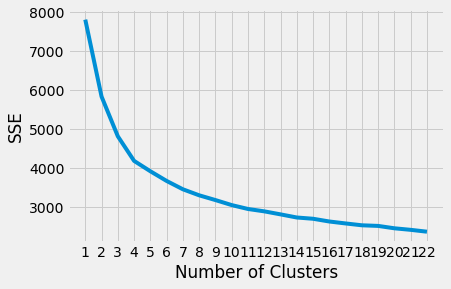

5


In [4]:
#use the kneed python module to find the knee point in the number of groups based on SSE
plt.style.use("fivethirtyeight")
plt.plot(range(1, 23), sse)
plt.xticks(range(1, 23))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
kl = KneeLocator(
range(1, 23), sse, curve="convex", direction="decreasing")
print(kl.elbow)
clusternum = kl.elbow


In [5]:
#We have determined the best number of groups is 5, so lets append our "data" df with each player's
#cluster and their euclidean distance from the centroid

kmeans = KMeans(init="random",n_clusters=clusternum,n_init=20,max_iter=300,random_state=42)#5,20
kmeans.fit(sdata)
print(kmeans.n_iter_, " iterations to complete")
distances = []
for i in range(len(sdata)): #find euclidean distance from respective cluster center
    cluster = kmeans.cluster_centers_[kmeans.labels_[i]]
    dist = np.linalg.norm(sdata[i] - cluster)
    distances.append(dist)
data['Cluster'] =  kmeans.labels_
data['Distance'] = distances
#print(data)
data.to_csv('best5yraverage.csv') #save the data to more easily parse and examine it

19  iterations to complete


## Cluster analysis

I ended up messing around with some different hyperparameters, and ended up with the process that you see above. The results were better than I expected, with some pretty clear roles being defined. So let's get into it!

### Cluster 4: The Paint Protectors
<br>**Analysis**  These players are not exactly backups (we avoided that by filtering by minutes/games played) but they are notable for their lack of scoring and high paint presence. It is obvious that in this cluster the algorithm isolated a group of players that performs well in getting rebounds and blocks, with a generally high 2 point percentage from getting dunks at the rim. While there are some great players here, like Rudy Gobert, Ben Wallace, Dennis Rodman, and Marc Gasol, the k-means algorithm seems stubborn to classify them here due to their lack of star level scoring output. 
<br>**Notable Players** Marc Gasol, Tristan Thompson, Udonis Haslem, Tyson Chandler, Marcus Camby, Brook Lopez, Hassan Whiteside, Serge Ibaka, Clint Capela, Rudy Gobert, Ben Wallace, DeAndre Jordan, Steven Adams
<br>**Notable Outliers** *Honestly I'm not claiming to have an extensive knowledge of historical mid-level big men, but this group does seem to be fairly consistent, with no huge outliers that I can pick out* 


### Cluster 3: The Heliocentric Star
<br>**Analysis**  This group can be best understood by the player closest to the centroid of the cluster: Russel Westbrook. This cluster consists of "system superstars". These players act as the focal point of their team in almost every way, with absurdly high attempt numbers in all categories, extreme scoring, and most distinguishingly, incredibly passing numbers. Any non-center face of the league can be found in this cluster. Interestingly, the furthest player from the centroid is **the** Michael Jeffrey Jordan, who likely sits so far from everyone due to his out-of-this-world scoring, even amongst his hall of fame peers in this group. This is the smallest cluster, an elite club infiltrated only by finals MVP Andre Iguodala...
<br>**Notable Players** Magic Johnson, Larry Bird, Stephen Curry,James Harden, LeBron James, Michael Jordan, Scotty Pippen, Chris Paul, Trae Young, Luka Doncic, Kobe Bryant, Allen Iverson, Dwyane Wade, Kevin Durant, Carmelo Anthony, and more...
<br>**Notable Outliers** Andre Iguodala

### Cluster 2: The "3 and D"
<br>**Analysis**  Ah, the 3 and D... A staple of modern basketball team construction, as general managers have wisened up to the realities of the NBA game as played today, the value of players who can recieve outlet passes from their cluster 3 superstars, shoot  pointers well enough to space the floor, and not get destroyed on defense has skyrocketed. This group features plenty of familiar names from the "original 3 and D guy" Shane Battier, to current NBA lineup stalwarts like George Hill, Duncan Robinson, Marcus Morris, and Avery Bradley. 
<br>**Notable Players**George Hill, Robert Horry, Raja Bell, Shane Battier, Kentavious Caldwell-Pope, PJ Tucker, Bojan Bogdanovich, Danny Green
<br>**Notable Outliers** D'Angelo Russel, Zach LaVine, Brandon Ingram

### Cluster 1: The Giants among Men
<br>**Analysis**  This cluster houses the league's best and biggest. Homing in on even more of the paint stats accrued by cluster 4, supercharged with extreme scoring numbers, the likes of Tim Duncan, Shaquille O'Neal, Kevin Garnett, and Hakeem Olajuwon can be found in this group. To my chagrin, the group seems focused on mostly scoring and paint stats, which unfortunately funnels in some "unicorn" big men like the passing savant Nikola Jokic and sharpshooting Karl Anthony-Towns. That being said, the star big men throughout the league's history seem to be accurately parsed and selected for this cluster. 
<br>**Notable Players** Hakeem Olajuwon, Anthony Davis, Pau Gasol, Dwight Howard, Joel Embiid, Andrei Kirilenko, Drik Nowitski 
<br>**Notable Outliers** Lamar Odom, Delef Schrempf, Zydrunas Ilgauskas (This is the best cluster for cool names, in case you didnt notice)

### Cluster 0: The "In-Betweeners"
**Analysis**  Finally we reach the last and most confounding cluster identified. This group seems to be an amalgamation of two different groups of players, and notably contains a few players that one would expect to fall into other groups already identified. The main connecting threads that I could find amongst the players in this cluster were 
1. Slashing shooting guards and point guards who did not shoot many 3 pointers, and gained most of their on court value driving to the rim and passing. 
2. pass first point guards with relatively low scoring output, such as Rajon Rondo or Draymond Green
Overall, it seems that this cluster gained many of of the "in between" non-big superstars who do not quite fall into cluster 3, but are still the focal point of their team. Notable exceptions include some excellent shooters such as Ray Allen, Klay Thompson, and Kyrie Irving, as well as some true superstars like Damian Lillard, Kawhi Leonard, and Steve Nash. 
<br>**Notable Players** Victor Oladipo, Shai Gilges-Alexander, De'Aaron Fox, Jimmy Butler, Ja Morant, Kyle Lowry, Steve Nash, Draymond Green, Rajon Rondo, Donovan Mitchell
<br>**Notable Outliers** Kyrie irving, Goran Dragic, Khris Middleton, Jamal Murray, Bradley Beal, Kawhi Leonard, Damian Lillard, Ray Allen, Kevin Love, Klay Thompson, CJ McCollum



In [6]:
#now to isolate metrics from each cluster: 
groups = []
for i in range(5):
    groups.append(data.drop(columns = ['Yr', 'Player', 'Cluster']).loc[data['Cluster'] == i].median())
    print('Data for group number: ', i)
    print(groups[-1])


Data for group number:  0
Height        76.000000
GS            67.700000
MP          2496.000000
3P            76.300000
3P%            0.343300
2P           359.400000
2P%            0.478400
FTA          286.300000
FT%            0.808200
ORB           60.400000
DRB          214.500000
AST          330.800000
STL           93.400000
BLK           20.500000
TOV          170.900000
PTS         1180.900000
Distance       2.247126
dtype: float64
Data for group number:  1
Height        82.0000
GS            71.0000
MP          2665.4000
3P             3.4000
3P%            0.2036
2P           525.4000
2P%            0.5096
FTA          417.2000
FT%            0.7428
ORB          200.2000
DRB          477.8000
AST          191.2000
STL           73.0000
BLK           89.8000
TOV          187.2000
PTS         1396.8000
Distance       2.4532
dtype: float64
Data for group number:  2
Height        78.000000
GS            53.500000
MP          2017.300000
3P            81.800000
3P%           

These data fit well with what we would expect from the groups described. Obviously the center groups average a greater height, as well as more of the stats commonly associated with height: Rebounds, blocks, and 2 point percentage (since dunks have a far higher percentage on average). The starter/star player archetypes obviously average more minutes played and games started, as well as far more points. Overall the data are somewhat hard to parse, so let's put this into a nicer visualization using one of my favorite plot types: radar plots, or spider plots

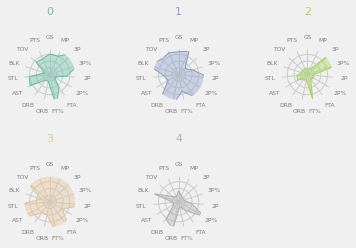

In [7]:
import matplotlib.pyplot as plt
from math import pi
from sklearn import preprocessing

stats = data
df = stats.loc[stats['Player'] == '']
cols = stats.columns[1:]
groups = []
for i in range(5):
    groups.append((stats.loc[stats['Cluster'] == i]).mean().to_numpy())

groups = np.array(groups)
min_max_scaler = preprocessing.MinMaxScaler()
sgroups = min_max_scaler.fit_transform(groups)
sgroups += 0.2

df = pd.DataFrame(data = sgroups, columns= cols).drop(columns=['Yr', 'Cluster', 'Distance', 'Height'])



def make_spider(row, title, color):
    # number of variable
    categories = list(df)#[1:]
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(2, 6, 2 * row + 1, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=6)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0, .25, .5, .75], [" ", " ", " ", " "], color="grey", size=7)
    plt.ylim(0, 1)
    # Ind1
    values = df.loc[row].drop(columns = ['Year']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=1, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.5)

    my_dpi = 96




# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
for row in range(0, len(df.index)):
    make_spider(row=row, title=row, color=my_palette(row))
    

plt.show()

This visualizes what I described before much more nicely. Stats are depicted as the radius of the plot, so it is important to pay no mind to the area of the plots themselves, but instead focus on the radius at each metric instead.  Note that the stats have been normalized so a stat with a radius of zero is simply the lowest value among the five clusters, and says nothing about the absolute value of the stat. 

Let's also take a more in depth look at how the clusters look, and how exactly they were separated by the K means algorithm. We have far too many dimensions to visualize all at once, so I will start by showing some scatter plots with different pairings of axis dimensions, and then use dimensionality reduction to try and visualize the entire clusters at once. 

                   Player    Yr  Height    GS      MP     3P     3P%     2P  \
0     Kareem Abdul-Jabbar  1980      86  47.0  2794.4    0.0  0.0000  772.4   
3          Tiny Archibald  1980      73  53.6  2140.0    3.8  0.2054  285.0   
7            Greg Ballard  1981      79  63.2  2752.2    9.0  0.2832  541.4   
17             Larry Bird  1981      81  74.6  3066.6   25.4  0.2884  745.2   
45        Bill Cartwright  1980      85  41.8  2618.0    0.0  0.0000  516.4   
...                   ...   ...     ...   ...     ...    ...     ...    ...   
3096       Darius Garland  2020      73  59.0  1824.0  105.0  0.3550  175.0   
3111      De'Andre Hunter  2020      80  62.0  2018.0  108.0  0.3550  172.0   
3137            Ja Morant  2020      75  67.0  2074.0   60.0  0.3350  387.0   
3143        Kendrick Nunn  2020      74  67.0  1962.0  137.0  0.3500  264.0   
3172      P.J. Washington  2020      79  57.0  1759.0   86.0  0.3740  182.0   

         2P%    FTA     FT%    ORB    DRB    AST   

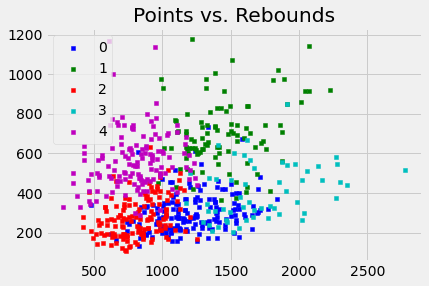

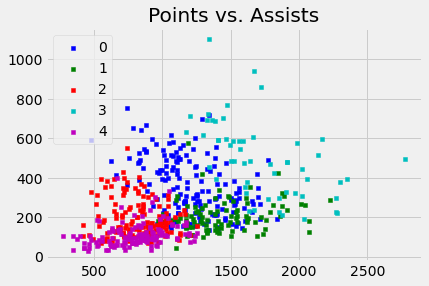

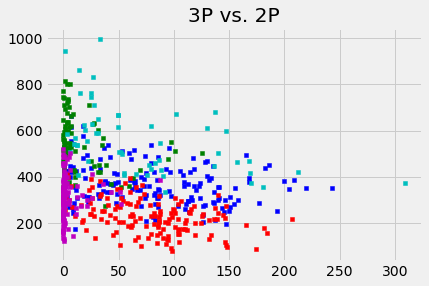

In [8]:
names = list(enumerate(stats['Player']))
print(stats)

a0 = stats.loc[stats['Cluster'] == 0]
a1 = stats.loc[stats['Cluster'] == 1]
a2 = stats.loc[stats['Cluster'] == 2]
a3 = stats.loc[stats['Cluster'] == 3]
a4 = stats.loc[stats['Cluster'] == 4]
######################################################
playerstolabel = ['Hakeem Olajuwon', "Shaquille O'Neal"]

x0,y0 = (a0['PTS']), (a0['ORB'] + a0['DRB'])#.to_numpy()
x1,y1 = (a1['PTS']), (a1['ORB'] + a1['DRB'])#.to_numpy()
x2,y2 = (a2['PTS']), (a2['ORB'] + a2['DRB'])#.to_numpy()
x3,y3 = (a3['PTS']), (a3['ORB'] + a3['DRB'])#.to_numpy()
x4,y4 = (a4['PTS']), (a4['ORB'] + a4['DRB'])#.to_numpy()
print(len(x0), len(y0))
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(x0,y0, s=10, c='b', marker="s", label='0')
ax1.scatter(x1,y1, s=10, c='g', marker="s", label='1')
ax1.scatter(x2,y2, s=10, c='r', marker="s", label='2')
ax1.scatter(x3,y3, s=10, c='c', marker="s", label='3')
ax1.scatter(x4,y4, s=10, c='m', marker="s", label='4')

plt.title('Points vs. Rebounds')
ax1.legend(loc='upper left');
'''for guy in names:
    if(guy[1] in playerstolabel):# or (clustrs[guy[0]] == 'g'):
        print(guy)
        print(type(x0), type(y0))
        ax1.annotate(guy[1],( x0.iloc[guy[0]], y0.iloc[guy[0]]))'''
plt.show()

################################################


x00,y00 = a0['PTS'], a0['AST']
x01,y01 = a1['PTS'], a1['AST']
x02,y02 = a2['PTS'], a2['AST']
x03,y03 = a3['PTS'], a3['AST']
x04,y04 = a4['PTS'], a4['AST']

fig2 = plt.figure()
ax01 = fig2.add_subplot()

ax01.scatter(x00,y00, s=10, c='b', marker="s", label='0')
ax01.scatter(x01,y01, s=10, c='g', marker="s", label='1')
ax01.scatter(x02,y02, s=10, c='r', marker="s", label='2')
ax01.scatter(x03,y03, s=10, c='c', marker="s", label='3')
ax01.scatter(x04,y04, s=10, c='m', marker="s", label='4')
plt.title('Points vs. Assists')
ax01.legend(loc='upper left');
plt.show()

#################################################33

x000,y000 = a0['3P'], a0['2P']
x001,y001 = a1['3P'], a1['2P']
x002,y002 = a2['3P'], a2['2P']
x003,y003 = a3['3P'], a3['2P']
x004,y004 = a4['3P'], a4['2P']

fig3 = plt.figure()
ax001 = fig3.add_subplot()

ax001.scatter(x000,y000, s=10, c='b', marker="s", label='0')
ax001.scatter(x001,y001, s=10, c='g', marker="s", label='1')
ax001.scatter(x002,y002, s=10, c='r', marker="s", label='2')
ax001.scatter(x003,y003, s=10, c='c', marker="s", label='3')
ax001.scatter(x004,y004, s=10, c='m', marker="s", label='4')
plt.title('3P vs. 2P')
ax01.legend(loc='upper left');
plt.show()

601
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 601 samples in 0.008s...
[t-SNE] Computed neighbors for 601 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 601 / 601
[t-SNE] Mean sigma: 126.880684
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.942089
[t-SNE] KL divergence after 2000 iterations: 0.727555


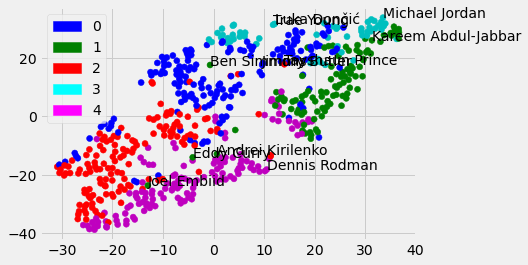

In [10]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches




playerstolabel = ['Kareem Abdul-Jabbar', 'Dennis Rodman', 'Michael Jordan', 'Tayshaun Prince','Eddy Curry', 
                 'Joel Embiid', 'Ben Simmons', 'Andrei Kirilenko','Luka Dončić', 'Trae Young', 'Jimmy Butler']
clustrs = data['Cluster']
def clustercolors(c):
    if(c == 0):
        return 'b'
    elif(c == 1):
        return 'g'
    elif(c == 2):
        return 'r'
    elif(c == 3):
        return 'c'
    elif (c == 4):
        return 'm'
    else: 
        return 'k'

clustrs = clustrs.apply(clustercolors).to_list()
print(len(clustrs))
stats1 = data.drop(columns = ['Player'])

tsne = TSNE(n_components=2, verbose=1,learning_rate = 35 ,perplexity=25, n_iter=2000,random_state = 100)#,init = 'pca')
tsne_results = tsne.fit_transform(stats1)

tsne_results
xx,yy = (list(zip(*tsne_results)))
fig, ax = plt.subplots()
ax.scatter(xx,yy, c = clustrs)
bpatch = mpatches.Patch(color='blue', label='0')
gpatch = mpatches.Patch(color='green', label='1')
rpatch = mpatches.Patch(color='red', label='2')
cpatch = mpatches.Patch(color='cyan', label='3')
mpatch = mpatches.Patch(color='magenta', label='4')
ax.legend(handles=[bpatch, gpatch, rpatch, cpatch, mpatch])
for guy in names:
    if(guy[1] in playerstolabel):# or (clustrs[guy[0]] == 'g'):
        ax.annotate(guy[1],( xx[guy[0]], yy[guy[0]]))
plt.show()


See here that with T-SNE Clustering instead, we get groupings fairly consistent with the K-means results. Some obvious outliers include some of the NBA's most peculiar players; the likes of Joel Embiid, Dennis Rodman, Andrei Kirilenko, and Ben Simmons. 

In [13]:
data1= data.loc[data["Height"] != 0]
for i in range(5):
    guys = data1.loc[data1['Cluster'] == i]
    biggest = (guys.loc[guys['Height'].idxmax()])
    smallest = (guys.loc[guys['Height'].idxmin()])
    print(f"cluster {i}'s biggest player: {biggest['Player']}")
    print(f"cluster {i}'s smallest player: {smallest['Player']}")
    #print(smallest['Player'], 'small')

cluster 0's biggest player: Mehmet Okur
cluster 0's smallest player: Muggsy Bogues
cluster 1's biggest player: Yao Ming
cluster 1's smallest player: Calvin Natt
cluster 2's biggest player: Kristaps Porziņģis
cluster 2's smallest player: Chucky Atkins
cluster 3's biggest player: Tom Chambers
cluster 3's smallest player: Allen Iverson
cluster 4's biggest player: Gheorghe Mureșan
cluster 4's smallest player: T.R. Dunn


Well, that's it! we can see it was moderately successful, with some of our unicorns being historical height outliers. Players such as "the best pound for pound player", "the answer" Allen Iverson, Big man superstart Tom Chambers, as well as our original unicorn Kristaps Prozingis! 